# Alineamientos

Funcion para crear el dotplot.
(DUDA: EN EL GRAFICO DE LA CLASE SE VEÍA DIFERENTE CON UN EJEMPLO... CONSULTAR)

In [1]:
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices

In [2]:
def read_fasta(filename):
    with open(filename,'r') as handle:
        r_seq = list(SeqIO.parse(handle, 'fasta'))
        return r_seq[0].seq, r_seq[1].seq

In [3]:
def read_fasta_to_list(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        seq_name = None
        seq_data = []

        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if seq_name:
                    sequences.append([ ''.join(seq_data), seq_name ])
                seq_name = line[1:]
                seq_data = []
            else:
                seq_data.append(line)

                # Guardar la última secuencia después de terminar el bucle
        if seq_name:
            sequences.append([ ''.join(seq_data), seq_name ])

    return sequences

In [4]:
class Alignment: 
    def __init__(self, seq1, seq2, k, type_of_sequences, threshold=0):
        """
        Genera la mejor alineación entre dos secuencias utilizando un dotplot filtrado.
        
        Args:
            seq1 (str): Primera secuencia a alinear.
            seq2 (str): Segunda secuencia a alinear.
            k (int): Tamaño de las submatrices cuadradas utilizadas en el filtrado del dotplot.
            t (str): Tipo de secuencia ('PROTEIN' o 'DNA').
        
        Returns:
            tuple: Una tupla que contiene la alineación traducida, el dotplot original, y el dotplot filtrado.
        
        Raises:
            ValueError: Si el tamaño `k` es mayor que las dimensiones de la matriz `dotplot`.
        """
        if len(seq1[0])<2 and len(seq2[0])<2:
            raise ValueError(f"El formato de la secuencia debe ser: [[sequence],'name of sequence']")
        if len(seq1[0]) <= len(seq2[0]):
            self.seq1 = seq1[0]
            self.seq2 = seq2[0]
        else:
            self.seq1 = seq2[0]
            self.seq2 = seq1[0]
        self.type_of_sequences = type_of_sequences.upper()
        self.seq1_label = seq1[1]
        self.seq2_label = seq2[1]
        if self.type_of_sequences == 'DNA':
            self.threshold = (k/2)
        elif threshold==0:
            self.threshold = self.__obtain_threshold()          
        if k > len(seq1[0]) or k > len(seq2[0]):
            raise ValueError(f"El tamaño de {k} debe ser menor al tamaño de la secuencia.")
        self.k = k

        self.dotplot = self.__make_dotplot(self.seq1, self.seq2)
        self.f_dotplot = self.__filtered_dotplot(k)
        self.best_alignment = self.__obtain_best_alignment()
        self.__traduced_alignment = self.__traduce_alignment()
        self.score = self.__get_score()

    def __get_score(self):
        score = 0.0
        for coord in self.best_alignment:
            score += self.dotplot[coord[0]][coord[1]]
        return score
    
    def __obtain_threshold(self):
        t_dotplot1, t_dotplot2 = self.__make_dotplot(self.seq1, self.seq1), self.__make_dotplot(self.seq2, self.seq2)
        i=0
        j=0
        threshold1, threshold2 = 0, 0
    
        while i < len(t_dotplot1) and j < len(t_dotplot1[0]):
            threshold1 += t_dotplot1[i, j]
            i+=1
            j+=1
        i=0
        j=0
        while i < len(t_dotplot2) and j < len(t_dotplot2[0]):
            threshold2 += t_dotplot2[i, j]
            i+=1
            j+=1
        threshold = ((threshold1/len(self.seq1)) + (threshold2/len(self.seq2))/2)
    
        return threshold

    def __traduce_alignment(self):
        traduced_seq = ''
        for i in range(len(self.best_alignment)):
            if self.seq1[self.best_alignment[i][0]] == self.seq2[self.best_alignment[i][1]]:
                traduced_seq += f"{self.seq1[self.best_alignment[i][0]]}{i}"
            else:
                # traduced_seq += f"{seq1[alignment_list[i-1][0]]}"
                # Si se prefiere un guion en vez de repetir la ultima base:
                traduced_seq += "-"
        return traduced_seq

    def __obtain_best_alignment(self):
        complete = False
        alignment_list = []
        i = 0
        j = 0
    
        while not complete:
            # Verificar si hemos llegado al final de alguna secuencia
            if i >= len(self.f_dotplot) or j >= len(self.f_dotplot[0]):
                complete = True
            else:
                alignment_list.append([i, j])  # Agregar la posición actual al alineamiento
    
                # Verificar si podemos movernos en diagonal
                if i + 1 < len(self.f_dotplot) and j + 1 < len(self.f_dotplot[0]) and self.f_dotplot[i + 1, j + 1] == 1:
                    i += 1
                    j += 1
                # Verificar si podemos movernos horizontalmente (gap en seq1)
                elif j + 1 < len(self.f_dotplot[0]) and self.f_dotplot[i, j + 1] == 1:
                    j += 1
                # Verificar si podemos movernos verticalmente (gap en seq2)
                elif i + 1 < len(self.f_dotplot) and self.f_dotplot[i + 1, j] == 1:
                    i += 1
                else:
                    if i<len(self.f_dotplot) and j<len(self.f_dotplot[0]):
                        j+=1
                    else:
                        complete = True
    
        return alignment_list



    def __has_potential(self, subdotplot):
        score = 0
        for i in range(len(subdotplot)):
            score += subdotplot[i,i]
    
        if score > self.threshold:
            return True
        return False
    
    def __filtered_dotplot(self,k):
        """
        Filtra una matriz de dotplot resaltando las regiones diagonales de tamaño k con mayor puntuación.
        
        La función evalúa las submatrices de tamaño `k x k` dentro de la matriz `dotplot`, buscando aquellas que tienen un número mayoritario de unos en su diagonal principal. Si la submatriz cumple con el criterio, se añade al dotplot filtrado.
        
        Returns:
            numpy.ndarray: Una nueva matriz del mismo tamaño que `dotplot`, donde las regiones que cumplen con 
            el criterio están resaltadas con unos en la diagonal.
        
        """
        rows, cols = len(self.dotplot), len(self.dotplot[0])
        f_dotplot = np.zeros((rows, cols))
    
        for i in range(rows-k+1):
            for j in range(cols-k+1):
                sub_dotplot = self.dotplot[i:i+k, j:j+k]
                if self.__has_potential(sub_dotplot):
                    if self.type_of_sequences == 'DNA':
                        f_dotplot[i:i+k, j:j+k] = sub_dotplot * np.eye(k)
                    elif self.type_of_sequences == 'PROTEIN':
                        f_dotplot[i,j]=1
    
        return f_dotplot

    def show_dotplot(self, filtered=False, show_values=False, show_alignment=False):
        
        if filtered:
            dtplt = self.f_dotplot
        else:
            dtplt = self.dotplot
            
        plt.imshow(dtplt, cmap="gray_r", interpolation='nearest')
        if not filtered:
            k_message = "SIN FILTRAR"     
        else:
            k_message = f"k={k}"
    
        if show_values:
            for i in range(len(dtplt)):
                for j in range(len(dtplt[0])):
                    value = dtplt[i][j]
                    plt.text(j, i, f'{value:.1f}', ha='center', va='center', color='red', fontsize=8)

        num_rows = len(dtplt)
        num_cols = len(dtplt[0])
        if num_rows > num_cols:
            point_size = num_rows/num_cols
        else: 
            point_size = num_cols/num_rows
        # Mostrar el alineamiento en rojo (opcional)
        if show_alignment and hasattr(self, 'best_alignment'):
            for alg in self.best_alignment:
                # Limitar los puntos a las dimensiones del dotplot
                if 0 <= alg[0] < num_rows and 0 <= alg[1] < num_cols:
                    plt.scatter(alg[1], alg[0], color='red', s=point_size)  # Trazar los puntos del alineamiento
                
        plt.title(f'Dotplot: {len(dtplt)} elementos vs {len(dtplt[0])} elementos | {k_message}')
        plt.xlabel(self.seq2_label)
        plt.ylabel(self.seq1_label)
        plt.show()
    
    def __prepare_seq_to_show_alignment(self, seq, position, len_of_seq2, len_score):
        prepared_seq = ""
        i=0
        while i < len_of_seq2:
            if i == position:
                j=0
                while j < len_score:
                    prepared_seq += seq[j]
                    j+=1
                i=i+j
            else:
                prepared_seq += "-"
            i+=1
        return prepared_seq
    
    def seq_string_equals(self, seq1, seq2):
        if self.seq1_label == seq1 and self.seq2_label == seq2:
            return True
        elif self.seq1_label == seq2 and self.seq2_label == seq1:
            return True
        else:
            return False
        
    def show_alignment(self):
        return self.__traduced_alignment
    
    def __make_dotplot(self, s1, s2):
        dotplot = np.zeros((len(s1),len(s2)))
    
        for i in range(len(s1)):
            for j in range(len(s2)):
                if self.type_of_sequences=='DNA':
                    if s1[i]==s2[j]:
                        dotplot[i,j] = 1
                else:
                    dotplot[i,j] = substitution_matrices.load('BLOSUM62')[s1[i],s2[j]]
    
        return dotplot


In [5]:
file = "./documents/TP53.fna"
seq1, seq2 = read_fasta(file)
seq1, seq2 = [seq1[:1000],'seq1'], [seq2[:1000],'seq2']

# Ventana de filtrado de alineamientos:
k = 30

alignment = Alignment(seq1, seq2, k, "dna")

# seq1 = 'TACG'
# seq2 = 'TATCG'
# k = 3
# threshold = (k/2)
# align, dotplot, f_dotplot = alignment(seq1, seq2, k, "ADN", threshold)

# RESULTADOS

#### Dotplot sin filtrar

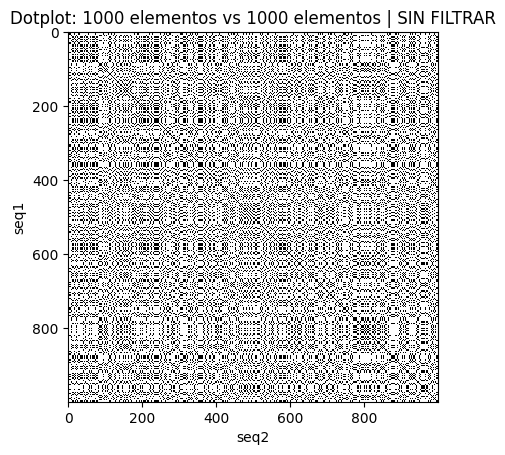

In [6]:
alignment.show_dotplot()

#### Dotplot filtrado

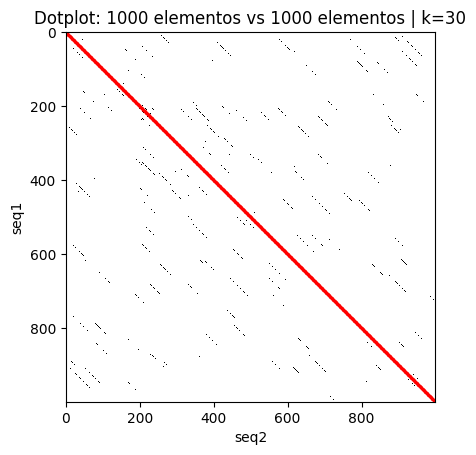

In [7]:
alignment.show_dotplot(filtered=True, show_alignment=True)

#### Mejor alineamiento

In [8]:
alignment.show_alignment()

'C0T1C2A3A4A5A6G7T8C9T10A11G12A13G14C15C16A17C18C19G20T21C22C23A24G25G26G27A28G29C30A31G32G33T34A35G36C37T38G39C40T41G42G43G44C45T46C47C48G49G50G51G52A53C54A55C56T57T58T59G60C61G62T63T64C65G66G67G68C69T70G71G72G73A74G75C76G77T78G79C80T81T82T83C84C85A86C87G88A89C90G91G92T93G94A95C96A97C98G99C100T101T102C103C104C105T106G107G108A109T110T111G112G113G114T115A116A117G118C119T120C121C122T123G124A125C126T127G128A129A130C131T132T133G134A135T136G137A138G139T140C141C142T143C144T145C146T147G148A149G150T151C152A153C154G155G156G157C158T159C160T161C162G163G164C165T166C167C168G169T170G171T172A173T174T175T176T177C178A179G180C181T182C183G184G185G186A187A188A189A190T191C192G193C194T195G196G197G198G199C200T201G202G203G204G205G206T207G208G209G210G211C212A213G214T215G216G217G218G219A220C221T222T223A224G225C226G227A228G229T230T231T232G233G234G235G236G237T238G239A240G241T242G243G244G245A246T247G248G249A250A251G252C253T254T255G256G257C258T259A260G261A262G263G264G265A266T267C268A269T270C271A272T273A274G275G276A

### Comparación con Biopython

Función de alineamiento de biopython

In [10]:
from Bio import pairwise2

# Realizar el alineamiento
al = pairwise2.align.globalxx(seq1[0], seq2[0])

# Imprimir los alineamientos
for a in al:
    print(pairwise2.format_alignment(*a))

CTCAAAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCGGGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTGACACGCTTCCCTGGATTGGGTAAGCTCCTGACTGAACTTGATGAGTCCTCTCTGAGTCACGGGCTCTCGGCTCCGTGTATTTTCAGCTCGGGAAAATCGCTGGGGCTGGGGGTGGGGCAGTGGGGACTTAGCGAGTTTGGGGGTGAGTGGGATGGAAGCTTGGCTAGAGGGATCATCATAGGAGTTGCATTGTTGGGAGACCTGGGTGTAGATGATGGGGATGTTAGGACCATCCGAACTCAAAGTTGAACGCCTAGGCAGAGGAGTGGAGCTTTGGGGAACCTTGAGCCGGCCTAAAGCGTACTTCTTTGCACATCCACCCGGTGCTGGGCGTAGGGAATCCCTGAAATAAAAGATGCACAAAGCATTGAGGTCTGAGACTTTTGGATCTCGAAACATTGAGAACTCATAGCTGTATATTTTAGAGCCCATGGCATCCTAGTGAAAACTGGGGCTCCATTCCGAAATGATCATTTGGGGGTGATCCGGGGAGCCCAAGCTGCTAAGGTCCCACAACTTCCGGACCTTTGTCCTTCCTGGAGCGATCTTTCCAGGCAGCCCCCGGCTCCGCTAGATGGAGAAAATCCAATTGAAGGCTGTCAGTCGTGGAAGTGAGAAGTGCTAAACCAGGGGTTTGCCCGCCAGGCCGAGGAGGACCGTCGCAATCTGAGAGGCCCGGCAGCCCTGTTATTGTTTGGCTCCACATTTACATTTCTGCCTCTTGCAGCAGCATTTCCGGTTTCTTTTTGCCGGAGCAGCTCACTATTCACCCGATGAGAGGGGAGGAGAGAGAGAGAAAATGTCCTTTAGGCCGGTTCCTCTTACTTGGCAGAGGGAGGCTGCTATTCTCCGCCTGCATTTCTTTTTCTGGATTACTTAGTTATGGCCTTTGCAAAGGCAGGGGT

/Users/agustincarmusciano/Desktop/Bioinformatica/bioinformatics/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# ALINEAMIENTO DE PROTEINAS

Utilizamos la misma funcion pero enviando 'PROTEIN' en el parametro t (tipo).

Y cargamos una proteina existente, tomando como primer secuencia los primeros 100 aminoacidos y en la segunda secuencia los primeros 150... para corroborar que haya match en los primeros 100.

In [11]:
prot = SeqIO.read("./documents/my_prot.txt","swiss")
prot_seq2 = [prot.seq[20:40],'seq2']
prot_seq1 = [prot.seq[:60],'seq1']
prot_k=3

# Threshold es opcional. Si no se le envia nada en ese parametro, la funcion calculara el umbral en base a la media del score de la diagonal principal de la primer secuencia
alignment_protein = Alignment(prot_seq1, prot_seq2, prot_k, "PROTEIN")

Grafico Sin filtrar

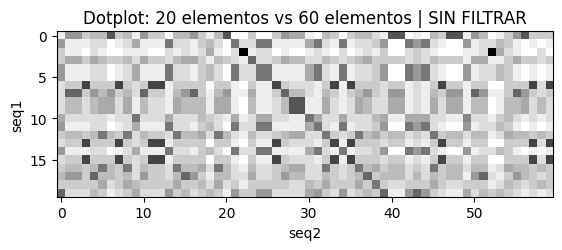

In [12]:
alignment_protein.show_dotplot()

Grafico filtrado

In [13]:
alignment_protein.type_of_sequences

'PROTEIN'

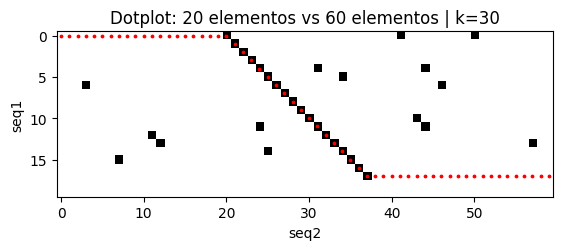

In [14]:
alignment_protein.show_dotplot(filtered=True, show_alignment=True)

Mejor alineamiento

In [17]:
alignment_protein.show_alignment()

'------D6-------------D20L21W22K23L24L25P26E27N28N29V30L31S32P33L34P35S36Q37-------------Q51--------'

# ALINEAMIENTO MULTIPLE

Obtenemos secuencias de proteinas con una funcion simple

In [18]:
def obtain_protein_sequence(prot,k):
    sequences = []
    i = 0
    num_of_seq = 1
    while i<=(len(prot)-k):
        sequences.append([prot.seq[i:i+k], f"seq{num_of_seq}"])
        num_of_seq += 1
        i+=k
    return sequences

In [19]:
# sequences = obtain_protein_sequence(prot,30)
sequences = read_fasta_to_list("./documents/sequences.fasta")
print(sequences)

[['MVLSPADKTNVKAAWGKVGAHAGA', 'Protein1'], ['MVLSPADKTNVKAAWGKVGAHAGE', 'Protein2'], ['MSSVTATGLILAHFRGRHSAEHAA', 'Protein3'], ['MALWMRLLLAHFRLALWGPLGAPG', 'Protein4'], ['MALWMRLLPLLALLALWGPLGAPG', 'Protein5'], ['MSSVTATGLILAHFRGRHSAEHAA', 'Protein6'], ['MAGKSPKNLAEELAGGVSLRAAIK', 'Protein7'], ['MAGKSPKNLAEELAGGVSLRAAIK', 'Protein8'], ['MTPIIPHGVMDRTPVALFRGAAYG', 'Protein9'], ['MAGKSPKNLAEELAGGPVALFRAA', 'Protein10']]


In [207]:
class AlignmentNode:

    def __init__(self, seq1, seq2, inner):
        self.inner = inner
        self.seq1 = seq1
        self.seq2 = seq2
        self.__list_of_traduced_alignments = []

    def __obtain_list_seqs(self, seq, label):
        k = len(label)
        if isinstance(seq, str):
            l = []
            i = 0
            while i < len(seq):
                if seq[i:i+k] == label:  # Encuentra 'seq'
                    j = i + k
                    # Encuentra el número después de 'seq'
                    while j < len(seq) and seq[j].isdigit():
                        j += 1
                    l.append(seq[i:j])  # Captura 'seq' seguido del número
                    i = j 
                else:
                    i += 1  # Avanza si no es 'seq'
            return l
        elif isinstance(seq, AlignmentNode):
            return seq.__obtain_list_seqs(seq.seq1,label)+(seq.__obtain_list_seqs(seq.seq2,label))
    
    # Función recursiva para traer los alineamientos
    def __recursive_alignment(self, seq, d_matrix, alignment):
        # Primero recorre de manera recursiva (excepto si la rama es str) trayendo la lista de mejores secuencias
        if isinstance(seq.seq1, str):
            seq_to_align_1 = [seq.seq1]
        else:
            seq_to_align_1 = self.__recursive_alignment(seq.seq1, d_matrix, alignment)
        if isinstance(seq.seq2, str):
            seq_to_align_2 = [seq.seq2]
        else:
            seq_to_align_2 = self.__recursive_alignment(seq.seq2, d_matrix, alignment)
        
        # Controla las secuencias traidas (todas contra todas) y se fija cual es la de menor distancia (mejor score)
        best_score = -np.inf
        best_seqs = []
        for i in range(len(seq_to_align_1)):
            for j in range(len(seq_to_align_2)):
                if d_matrix.loc[seq_to_align_1[i]][seq_to_align_2[j]] > best_score:
                    best_score = d_matrix.loc[seq_to_align_1[i]][seq_to_align_2[j]]
                    best_seqs = [seq_to_align_1[i], seq_to_align_2[j]]
        
        # Recorre la lista de alineamientos y busca el alineamiento que coincide con el mejor score obtenido previamente
        for algn in alignment:
            if algn.seq_string_equals(best_seqs[0], best_seqs[1]):
                self.__list_of_traduced_alignments.append([algn.show_alignment(), best_seqs])
                break
                
        return best_seqs
            
    def alignment(self, d_matrix, alignments):
        self.__recursive_alignment(self, d_matrix, alignments)
        return self.__list_of_traduced_alignments.copy()
    
    def contains_seq(self, seq, label):
        list = self.__obtain_list_seqs(self, label)
        list2 = self.__obtain_list_seqs(seq, label)
        for seq1 in list: 
            for seq2 in list2:
                if seq1 == seq2:
                    return True
        return False
            
    
    def __str__(self):
        return f"({self.seq1}, {self.seq2})"



In [265]:
class Tree:
    
    def __init__(self):
        self.__inners = {}
        self.__tree_inners = {}
        self.__elements = []
        self.__tree_alignments = []
        self.__inner = 1
        self.__inner_tree = 1
        self.__waiting = None
        self.__newick = ""
        
    def __increment_inner(self, tree=False):
        if tree:
            self.__inner_tree += 1
        else:
            self.__inner += 1
    
    def __search_element(self, elem, tree=False):
        if tree:
            if elem in self.__tree_inners:
                return self.__tree_inners[elem]
            else:
                return None
        else:
            if elem in self.__inners:
                return self.__inners[elem]
            else:
                return None
    
    def __obtain_element(self, inner, tree=False):
        if tree:
            for elem in self.__tree_inners:
                if elem.inner == inner:
                    return elem
        else:
            for elem in self.__elements:
                if elem.inner == inner:
                    return elem
            
    def __create_branch(self, elem):
        inner1 = self.__search_element(self.__waiting, tree=True)
        inner2 = self.__search_element(elem, tree=True)
    
        elem1 = self.__obtain_element(inner1, tree=True) if inner1 else self.__waiting
        elem2 = self.__obtain_element(inner2, tree=True) if inner2 else elem
    
        align = AlignmentNode(elem1, elem2, self.__inner)
    
        self.__inners[str(align)] = self.__inner
    
        self.__increment_inner()  
        self.__tree_alignments.insert(0,align)
        self.__newick = str(align)
        self.__waiting = None
        
    def set_node(self, elem1, elem2):
        inner1 = self.__search_element(elem1)
        inner2 = self.__search_element(elem2)
    
        elem1 = self.__obtain_element(inner1) if inner1 else elem1
        elem2 = self.__obtain_element(inner2) if inner2 else elem2
    
        align = AlignmentNode(elem1, elem2, self.__inner)

        self.__inners[str(align)] = self.__inner

        self.__increment_inner()
    
        if self.__waiting is None:
            self.__waiting = align
        else:
            self.__create_branch(align)

        self.__elements.insert(0, align)

    def show_alignments(self, d_matrix, alignments, elements):
        if elements:
            iterable = self.__elements[0]
        else:
            iterable = self.__tree_alignments[0]
            
        for align in iterable.alignment(d_matrix, alignments):
            print(f"Secuencias: {align[1][0], align[1][1]}\n"
                  f"Alineamiento: {align[0]}\n"
                  f"{'_'*30}")

    def get_last_alignment(self):
        return self.__elements[0]
    
    def get_newick(self, elements):
        if elements:
            return str(self.__elements[0])
        return self.__newick
        
        
    

### Como calcular la matriz de distancia para el alineamiento multiple

1. **Buscar el par con menor distancia**

2. **Formar un nodo con esos elementos**

3. **Recalcula la matriz**: $$d(e1e2-j) = \frac{d(e1-j) + d(e2-j)}{2}$$

4. **Repetir el proceso**


In [1]:
from Bio import Phylo
from io import StringIO
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage

class MultipleAlignment:   
    def __init__(self, sequences, type_of_sequences="DNA"):
        # Lista de nodos de alineamiento
        self.list_of_nodes = []
        
        self.__tree = Tree()
        # Alineamientos totales (util para graficar el arbol)
        self.alignments = None
        # Historial de matriz de distancia, permite controlar la iteracion completa
        self.matrix_history = []
        # Nombre de las secuencias
        self.label_of_sequences = ""
        # Matriz de distancia inicial
        self.distance_matrix = None
        # Alineamientos iniciales
        self.sequences_alignments = []
        # Secuencias a alinear
        self.sequences = sequences
        type_of_sequences = type_of_sequences.upper()
        if type_of_sequences == "DNA" or type_of_sequences == "PROTEIN":     
                self.type_of_sequences = type_of_sequences
        else:
            raise ValueError("type_of_sequences debe ser DNA o PROTEIN")
        if self.__check_sequences():        
            self.matrix = self.__obtain_matrix()
        else:
            raise ValueError("El formato de la secuencia tiene que ser:  [[sequence],'name of sequence']")

    def __check_sequences(self):
        # Verificar que la lista contenga tuplas o listas con dos elementos
        if not isinstance(self.sequences, list):
            return False
    
        for item in self.sequences:
            if not isinstance(item, (tuple, list)) or len(item) != 2:
                return False
    
            sequence, name = item
            
            if self.type_of_sequences == "DNA":
                # Verificar que la secuencia sea una cadena que solo contenga A, T, C, G
                if not isinstance(sequence, str) or not all(base in 'ATCG' for base in sequence.upper()):
                    raise ValueError(f"La secuencia es: '{self.type_of_sequences}' pero no contiene 'ATCG'")
                
            # Verificar que el nombre sea una cadena
            if not isinstance(name, str):
                raise ValueError(f"El nombre de la secuencia tiene que ser un String")
    
        return True

    
    # Dibuja el dendograma
    def draw_tree(self, elements=False):  
        tree = Phylo.read(StringIO(f"{self.__tree.get_newick(elements)}"), "newick")
        tree.ladderize()
        Phylo.draw(tree)

    
    # Muestra todos los alineamientos respetando el dendograma
    def show_alignment(self, elements):
        self.__tree.show_alignments(self.distance_matrix, self.sequences_alignments, elements)
    
    def obtain_alignment(self, seq1, seq2):
        for alignment in self.sequences_alignments:
            if alignment.seq_string_equals(seq1, seq2):
                return alignment
    
    # Encuentra las secuencias con score mas cercano
    def __closest_neighbor(self,matrix):
        pair = []
        best_distance = -np.inf
        for i in range(len(matrix.index)):
            for j in range(i+1,len(matrix.columns)):
                distance = matrix.loc[matrix.index[i], matrix.columns[j]]
                if distance >= best_distance:
                    pair=[matrix.index[i], matrix.columns[j]]
                    best_distance = matrix.loc[matrix.index[i], matrix.columns[j]]
        return pair[0], pair[1]
    
    # Revisa si existe el nodo, de ser asi lo devuelve
    def __check_if_exists_node(self, seq):
        r = None
        for node in self.list_of_nodes:
            if node.contains_seq(seq, self.label_of_sequences):
                r = node
            
        if r is None:
            return seq
        else:
            self.list_of_nodes.remove(r)
            return r
    
    # Se edita la matriz eliminando las columnas y las filas de los nodos conectados, y creando una nueva con el nodo nuevo.
    def __edit_matrix(self,matrix, row, column):
        seq1 = row
        seq2 = column
        
        df_copy = matrix.copy()
        matrix = matrix.drop(index=seq1, columns=seq2)
        matrix = matrix.drop(index=seq2, columns=seq1)
        
        self.__tree.set_node(seq1, seq2)
        align_node = self.__tree.get_last_alignment()
        self.list_of_nodes.append(align_node)
        # Insertar una columna llena de ceros en la posición dinámica
        
        matrix.insert(0, f'{align_node}', [0] * len(matrix))
        
        # Crear una fila llena de ceros para insertar con un nombre específico
        new_row = pd.DataFrame([[0] * len(matrix.columns)], columns=matrix.columns, index=[f'{align_node}'])
        
        # Insertar la fila en la posición dinámica
        matrix = pd.concat([new_row, matrix.iloc[0:]])

        matrix = matrix.astype(float)
        
        node1_str = str(align_node.seq1) 
        node2_str = str(align_node.seq2)
        
        # Reasigna valores a la matriz (en las filas y columnas nuevas hace la formula mencionada en el markdown de arriba)
        for i in range(len(matrix.index)):
            for j in range(i+1,len(matrix.columns)): 
                if matrix.index[i] == f"{align_node}": 
                    matrix.loc[matrix.index[i],matrix.columns[j]] = (df_copy.loc[matrix.columns[j], node1_str]  + df_copy.loc[matrix.columns[j],node2_str])/2
                elif matrix.columns[j] == f"{align_node}":
                    matrix.loc[matrix.index[i],matrix.columns[j]] = (df_copy.loc[node1_str,matrix.index[i]]  + df_copy.loc[node2_str,matrix.index[i]])/2
                else:
                    matrix.loc[matrix.index[i],matrix.columns[j]] = df_copy.loc[matrix.index[i],matrix.columns[j]]       
        return matrix, align_node
    
    # Alinea las secuencias
    def __align_seq(self, seq1, seq2):
        align = pairwise2.align.globalxx(seq1, seq2)
        return align[0].score
    
    # Obtiene la matriz de distancia
    def __d_matrix(self):
        n = len(self.sequences)
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                new_align = Alignment(self.sequences[i], self.sequences[j], 3, self.type_of_sequences)
                self.sequences_alignments.append(new_align)
                matrix[i, j] = new_align.score
        df_distance_matrix = pd.DataFrame(matrix)
        self.label_of_sequences = self.sequences[0][1][:-1]
        df_distance_matrix.columns = [x[1] for x in self.sequences]
        df_distance_matrix.index = [x[1] for x in self.sequences]

        return df_distance_matrix
    
    # Función principal de la clase, mediante esta va obteniendo la matriz y generando los nodos
    def __obtain_matrix(self):
        # Obtiene la matriz de distancia de las secuencias (compara todas con todas)
        matrix = self.__d_matrix()
        # Convertir las secuencias en objetos SeqRecord
        self.distance_matrix = matrix
        while len(matrix)>1:
            self.matrix_history.append(matrix)
            row, column = self.__closest_neighbor(matrix)
            matrix, align_node = self.__edit_matrix(matrix, row, column)
            self.alignments = align_node

    
        
        

ModuleNotFoundError: No module named 'pandas'

In [286]:
ma = MultipleAlignment(sequences,"protein")

In [287]:
print(ma.alignments)

((((Protein1, Protein2), Protein10), ((Protein5, Protein9), Protein4)), ((Protein7, Protein8), (Protein3, Protein6)))


In [288]:
ma.matrix_history

[           Protein1  Protein2  Protein3  Protein4  Protein5  Protein6  \
 Protein1        0.0     114.0     -19.0       1.0       6.0     -19.0   
 Protein2        0.0       0.0     -19.0       1.0       6.0     -19.0   
 Protein3        0.0       0.0       0.0       1.0       6.0     108.0   
 Protein4        0.0       0.0       0.0       0.0       0.0     -15.0   
 Protein5        0.0       0.0       0.0       0.0       0.0     -15.0   
 Protein6        0.0       0.0       0.0       0.0       0.0       0.0   
 Protein7        0.0       0.0       0.0       0.0       0.0       0.0   
 Protein8        0.0       0.0       0.0       0.0       0.0       0.0   
 Protein9        0.0       0.0       0.0       0.0       0.0       0.0   
 Protein10       0.0       0.0       0.0       0.0       0.0       0.0   
 
            Protein7  Protein8  Protein9  Protein10  
 Protein1      -15.0     -15.0     -12.0      -17.0  
 Protein2      -15.0     -15.0     -12.0      -17.0  
 Protein3      -15.0  

In [289]:
ma.distance_matrix

,Protein1,Protein2,Protein3,Protein4,Protein5,Protein6,Protein7,Protein8,Protein9,Protein10
Protein1,0.0,114.0,-19.0,1.0,6.0,-19.0,-15.0,-15.0,-12.0,-17.0
Protein2,0.0,0.0,-19.0,1.0,6.0,-19.0,-15.0,-15.0,-12.0,-17.0
Protein3,0.0,0.0,0.0,1.0,6.0,108.0,-15.0,-15.0,-12.0,-17.0
Protein4,0.0,0.0,0.0,0.0,0.0,-15.0,-15.0,-15.0,3.0,-7.0
Protein5,0.0,0.0,0.0,0.0,0.0,-15.0,-15.0,-15.0,3.0,-7.0
Protein6,0.0,0.0,0.0,0.0,0.0,0.0,-15.0,-15.0,-12.0,-17.0
Protein7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,-12.0,66.0
Protein8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,66.0
Protein9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0
Protein10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [290]:
ma.show_alignment(elements=False)

Secuencias: ('Protein7', 'Protein8')
Alineamiento: M0A1G2K3S4P5K6N7L8A9E10E11L12A13G14G15V16S17L18R19A20A21--
______________________________
Secuencias: ('Protein3', 'Protein6')
Alineamiento: M0S1S2V3T4A5T6G7L8I9L10A11H12F13R14G15R16H17S18A19E20H21--
______________________________
Secuencias: ('Protein7', 'Protein3')
Alineamiento: M0-----------------------
______________________________
Secuencias: ('Protein1', 'Protein2')
Alineamiento: M0V1L2S3P4A5D6K7T8N9V10K11A12A13W14G15K16V17G18A19H20A21--
______________________________
Secuencias: ('Protein1', 'Protein10')
Alineamiento: M0-----------------------
______________________________
Secuencias: ('Protein5', 'Protein9')
Alineamiento: M0--------M9-----A15----A20A21--
______________________________
Secuencias: ('Protein5', 'Protein4')
Alineamiento: M0A1L2W3M4R5------------------
______________________________
Secuencias: ('Protein1', 'Protein5')
Alineamiento: M0---M4-------------------
______________________________
Secuencias: ('Protein3'

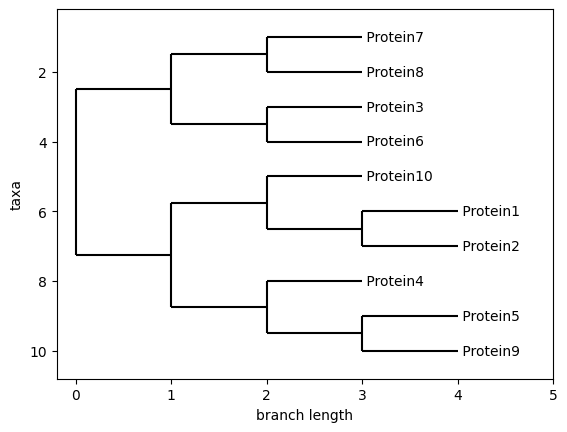

In [291]:
ma.draw_tree()

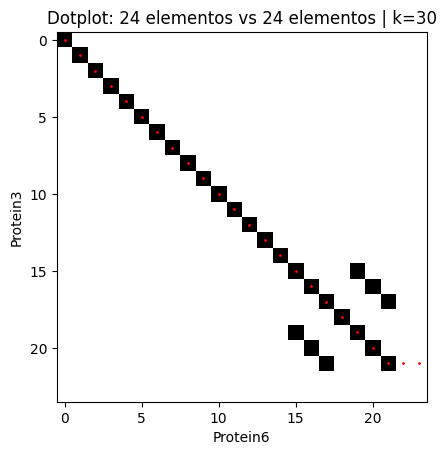

In [35]:
ma.obtain_alignment('Protein6', 'Protein3').show_dotplot(filtered=True,show_alignment=True)

Ejemplo de como funciona con otras secuencias mas chicas

In [36]:
sqs_prot = [('NWKRKCYVWISACSYNEWIC', 'protein_1'),
            ('NWKRKCYVWISACSYNEWIC', 'protein_2'),
            ('NWKRKCYVWISACSYNEWIC', 'protein_3'),
            ('ACGYCYVWISACSYNEWIC', 'protein_4'),
            ('ACGIKCYVWISACSYNEWIC', 'protein_5')]
sqs_adn = [('TACCCTTCGCGCCTGCGTATTAGATGGCTTGCTGGAGGGGCAGGCTGAGA','seq1'),
           ('GTCGCGTTACTTTGTTTAGGGAGTTATACCATTGTTATGTTCTTAACCTT','seq2'),
           ('TACCCTTCGCGCCTGCGTATTAGATGGCTTGAGGGAGGGGCAGGCTGAGA','seq3'),
           ('GTCGCGTTACTTTGTTTAGGGAGTTATACCATTGTTATGTTCTTAACCTT','seq4'),
           ('AAATGCTTTTCGAACCGAAACGCGAAAAACATAGTATCACATTCGTCTGA','seq5')]

ma2 = MultipleAlignment(sqs_adn,"DNA")

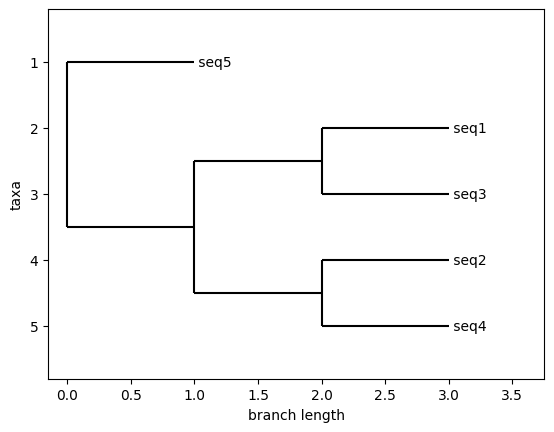

In [37]:
ma2.draw_tree()

In [38]:
ma2.show_alignment()

Secuencias: ('seq1', 'seq3')
Alineamiento: T0A1C2C3C4T5T6C7G8C9G10C11C12T13G14C15G16T17A18T19T20A21G22A23T24G25G26C27T28T29G30-G32G33G34-G36G37G38G39C40---C44T45----
______________________________
Secuencias: ('seq2', 'seq4')
Alineamiento: G0T1C2G3C4G5T6T7A8C9T10T11T12G13T14T15T16A17G18G19G20A21G22T23T24A25T26A27C28C29A30T31T32G33T34T35A36T37G38T39T40C41T42T43A44A45C46C47T48T49
______________________________
Secuencias: ('seq1', 'seq2')
Alineamiento: -T1----T6T7A8C9C10C11T12T13T14-T16T17T18------T25T26-T28-C30C31---G35----G40-----------
______________________________
Secuencias: ('seq1', 'seq5')
Alineamiento: ---T3--T6T7T8T9--A12A13C14C15C16----C21-C23------C30-------C38-C40-T42T43C44--C47---
______________________________


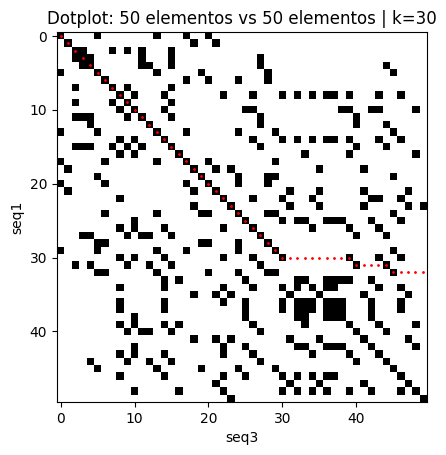

In [39]:
ma2.obtain_alignment('seq1', 'seq3').show_dotplot(show_alignment=True, filtered=True)

### Comparación con alineamiento BLAST

In [40]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

# Convertir las secuencias en objetos SeqRecord
seq_records = [SeqRecord(seq[0], id=seq[1]) for seq in sequences]

# Crear un objeto MultipleSeqAlignment con las secuencias
alignment = MultipleSeqAlignment(seq_records)

# Calcular la matriz de distancias con el calculador de identidad
calculator = DistanceCalculator('identity')
distMatrix = calculator.get_distance(alignment)


/Users/agustincarmusciano/Desktop/Bioinformatica/bioinformatics/lib/python3.11/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [41]:
print(distMatrix)

Protein1    0.000000
Protein2    0.041667    0.000000
Protein3    0.791667    0.833333    0.000000
Protein4    0.875000    0.875000    0.916667    0.000000
Protein5    0.875000    0.875000    0.875000    0.208333    0.000000
Protein6    0.791667    0.833333    0.000000    0.916667    0.875000    0.000000
Protein7    0.833333    0.833333    0.875000    0.791667    0.833333    0.875000    0.000000
Protein8    0.833333    0.833333    0.875000    0.791667    0.833333    0.875000    0.000000    0.000000
Protein9    0.916667    0.916667    0.916667    0.875000    0.875000    0.916667    0.833333    0.833333    0.000000
Protein10   0.791667    0.833333    0.791667    0.791667    0.833333    0.791667    0.333333    0.333333    0.916667    0.000000
    Protein1    Protein2    Protein3    Protein4    Protein5    Protein6    Protein7    Protein8    Protein9    Protein10


In [42]:
constructor = DistanceTreeConstructor()
UPGMATree = constructor.upgma(distMatrix)

In [43]:
print(UPGMATree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner9')
        Clade(branch_length=0.44791666666666663, name='Protein9')
        Clade(branch_length=0.28124999999999994, name='Inner8')
            Clade(branch_length=0.26171874999999994, name='Inner6')
                Clade(branch_length=0.23958333333333331, name='Inner5')
                    Clade(branch_length=0.16666666666666669, name='Protein10')
                    Clade(branch_length=0.16666666666666669, name='Inner1')
                        Clade(branch_length=0.0, name='Protein8')
                        Clade(branch_length=0.0, name='Protein7')
                Clade(branch_length=0.3020833333333333, name='Inner4')
                    Clade(branch_length=0.10416666666666669, name='Protein5')
                    Clade(branch_length=0.10416666666666669, name='Protein4')
            Clade(branch_length=0.4075520833333333, name='Inner7')
                Clade(branch_length=0.40625, name='Inner2')
                    Clade(bra

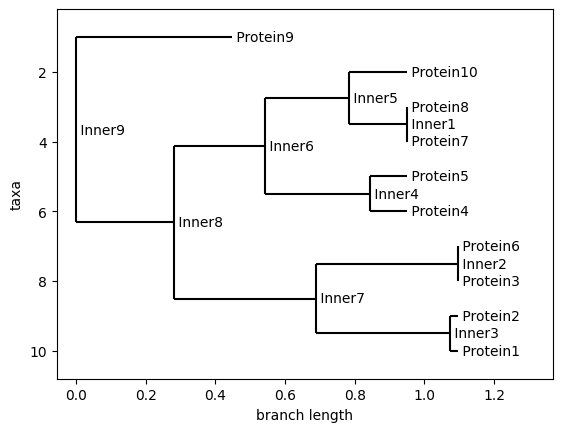

In [44]:
Phylo.draw(UPGMATree)